<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC2: Deep Reinforcement Learning


En esta práctica se implementarán tres modelos de DRL en un mismo entorno, con el objetivo de analizar distintas formas de aprendizaje de un agente y estudiar su rendimiento. El agente será entrenado con los métodos:

<ol>
    <li>DQN</li>
    <li>Dueling DQN</li>
    <li>REINFORCE with baseline </li>
 </ol>

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File  →  Download as  →  HTML.**

**Es necesario adjuntar en la entrega los ficheros .pth con los diferentes modelos entrenados.**

No es necesario adjuntar los ficheros .gif

## 0. Contexto

Uno de los objetivos más actuales del campo de la robótica es conseguir que un robot sea capaz de aprender a realizar una serie de acciones por si sólo, del mismo modo que lo hace un niño pequeño. Esta es, básicamente, una de las principales motivaciones del aprendizaje por refuerzo profundo. Para ello se necesitan sistemas de control eficientes en entornos de alta dimensionalidad como puede ser la inversión en bolsa, conducción de coches autónomos o, incluso, el control de cohetes espaciales. Con esta idea, en esta práctica usaremos un entorno ya predefinido en OpenAI, **Space Invader**.

**Space Invader** consiste en un cañón que puede disparar hacia arriba y moverse de izquierda a derecha. El objetivo del juego es destruir a los extraterrestres enemigos, que se acercan cada vez más rápido al jugador a medida que este los elimina, y maximiza la puntuación. En este entorno, la observación es una imagen RGB de la pantalla representada por una matriz de forma (210, 160, 3) cómo se observa a continuación.




![title](videos/random_agent_space_invader.gif)


Rango de acciones:
* NOOP: 0 ( No operacion).
* FIRE: 1 (disparar sin moverse)
* RIGHT: 2 (mover a la derecha)
* LEFT: 3 (mover a la izquierda)
* RIGHTFIRE: 4 (disparar y mover a la derecha)
* LEFTFIRE: 5 (disparar y mover a la izquierda)


Recompensa: La recompensa devuelta por el entorno está compuesta por un valor en el rango [0, 30]. Dependiendo de la nave alienígena destruida, el agente recibe una puntuación diferente.
 Nuestra tarea es enseñarle una política que le permita hacer una elección "buena" para cada estado.

Para más detalles sobre la definición del entorno de Space Invader, se recomienda consultar las web: <href>https://www.gymlibrary.dev/environments/atari/space_invaders/</href> y  <href>https://atariage.com/manual_html_page.php?SoftwareLabelID=460</href>


## 1. Inicialización y exploración del entorno (1 pto)
**IMPORTANTE**: el entorno Space Invader depende de la instalación de los siguientes paquetes
<ul>
     <li>gym[atari] en la versión 0.25.0</li>
     <li>autorom[accept-rom-license]</li>
</ul>

Este entorno puede ser ejecutado tanto en local como en Kaggle con la versión de GPU P100 y en Google Colab. Recomiendo utlizar Kaggle para los estudiantes que no dispongan de una GPU en local.

Empezaremos cargando las principales librerías necesarias para la práctica:


In [1]:
#instalación de librerías.
import warnings
warnings.filterwarnings('ignore')
import time
!pip install gym[atari]==0.25.0
!pip install autorom[accept-rom-license]
!pip install imageio
!pip install matplotlib
import gym
import torch
import matplotlib.pyplot as plt
from ale_py import ALEInterface
ale = ALEInterface()
from ale_py.roms import SpaceInvaders
ale.loadROM(SpaceInvaders)
import numpy as np
import os
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
!pip install scikit-image
from skimage import transform
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import pickle

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
Game console created:
  ROM file:  /home/geviar/anaconda3/envs/rl/lib/python3.10/site-packages/AutoROM/roms/space_invaders.bin
  Cart Name: Space Invaders (1978) (Atari) [!]
  Cart MD5:  72ffbef6504b75e69ee1045af9075f66
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        4096
  Bankswitch Type: AUTO-DETECT ==> 4K

Running ROM file...
Random seed is 1670328284


/home/geviar/anaconda3/envs/rl/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [2]:
# Comprobación de la versión de GYM instalada
print('La versión de gym instala: ' + gym.__version__)
# Comprobación de entorno con gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("El entorno utiliza: ", device)

La versión de gym instala: 0.25.0
El entorno utiliza:  cuda



Comprueba que la celda anterior indica que la verisón instalada de Gym es la 0.25.0.


Listamos los dispositivos CUDA disponibles con sus propiedades.

In [3]:
for i in range(torch.cuda.device_count()): 
    print(f'Device #{i}: {torch.cuda.get_device_name(i)}')
    print(f'Properties: {torch.cuda.get_device_properties(i)}\n')

Device #0: NVIDIA GeForce RTX 3070
Properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3070', major=8, minor=6, total_memory=8191MB, multi_processor_count=46)

Device #1: NVIDIA GeForce RTX 2060 SUPER
Properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 2060 SUPER', major=7, minor=5, total_memory=8191MB, multi_processor_count=34)



In [4]:
from tqdm.notebook import tqdm
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Set Seaborn aesthetics
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titlelocation'] = 'left'
plt.style.use('ggplot')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.2 ptos):</strong> Inicializar el entorno 'SpaceInvaders-v4'. Extraer:
<ul>
 <li> Valor del umbral de recompensa definido en el entorno</li>
 <li> Máximo número de pasos establecidos para cada episodio</li>
 <li> La dimensión del espacio de acciones</li>
 <li> La dimensión del espacio de observaciones.</li>
 </ul>
</div>


In [5]:
warnings.filterwarnings('ignore')
env = gym.make('SpaceInvaders-v4')

##TODO:
####
print(f'Reward threshold is: {env.spec.reward_threshold}')
print(f'Reward range is: {env.reward_range}')
print(f'Maximun number of steps per episode: {env.spec.max_episode_steps}')
print(f'Action space dimmension is: {env.action_space.n}')
print(f'Actions are: {env.unwrapped.get_action_meanings()}')
print(f'Observation space dimmension is: {env.observation_space.shape}')

Reward threshold is: None
Reward range is: (-inf, inf)
Maximun number of steps per episode: 100000
Action space dimmension is: 6
Actions are: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Observation space dimmension is: (210, 160, 3)


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


Podemos ver como no tenemos una recompensa a partir de la cual se considere el juego superado, pero sí que tenemos un número de pasos máximos de 100.000. Por otro lado, el espacio de acciones es 6 (no hacer nada, disparar, desplazar a izquierda y derecha, y desplazar a izquierda y derecha y disparar) y el de estados es una matriz de 210x160x3, correspondiente a una imagen RGB de 210x160 píxels.

En el aprendizaje por refuerzo suele ser muy útil visualizar el comportamiento de un agente en su entorno. Para esta PEC es interesante poder almacenar el comportamiento visual de un agente en forma de archivo .gif.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.2 ptos):</strong>  En este ejericicio os proponemos almacenar en una carpeta videos un ejemplo de actuación del agente aleatorio en forma de archivo .gif.

    -----------------------------------------------------------------------------------------------------------
    
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.
</div>


In [6]:
#Método para generar la imagen a partir de un estado con un texto informativo.
def _label_with_text(frame):
    '''
    frame: estado de un entorno GYM.
    '''
    im = Image.fromarray(frame)
    im = im.resize((im.size[0]*2,im.size[1]*2))
    drawer = ImageDraw.Draw(im)
    drawer.text((1, 1), "Uoc Aprendizaje Por Refuerzo.", fill=(255, 255, 255, 128))
    return im

#Método que permite crear un gif con la evolución de una partida dado un entorno GYM.
def save_random_agent_gif(env):
    frames = []
    done = False
    env.reset()
    ###########################################
    #TODO Jugar una partida aleatoria.
    while not done:
        action = env.action_space.sample()
        frame = env.render(mode='rgb_array')
        frames.append(_label_with_text(frame))
        state, _, done, _ = env.step(action)
    ##############################################

    env.close()
    imageio.mimwrite(os.path.join('./videos/', 'random_agent_space_invader_usuario.gif'), frames, fps=60)

In [7]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
try:
    os.makedirs('videos')
except:
    pass
save_random_agent_gif(env)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.3 (0.3 ptos):</strong> Ejecutar 1000 episodios con el máximo de pasos establecido en el entorno de Space Invader, tomando acciones de forma aleatoria. Almacenar la suma de recompensas de cada partida y la cantidad de episodios ejecutados. Mostrar:
    <ul>
       <li>Histograma con la suma de recompensas de cada partida</li>
       <li>Histograma con la cantidad de pasos para resolver cada partida. </li>
    </ul>
</div>

In [8]:
def play_random_episode(env:gym.Env) -> float:
    '''Plays a random episode and returns the total reward and number of steps taken'''
    # Environment initialization
    obs = env.reset()
    total_reward, done = 0, False
    n_steps = env.spec.max_episode_steps

    for i in range(n_steps):
        # Elegir una acción aleatoria (implementación del agente)
        action = env.action_space.sample()
        # Ejecutar la acción y esperar la respuesta del entorno
        new_obs, reward, done, info = env.step(action)
        if done:
            n_steps = i + 1
            break
        # Actualizar variables
        obs = new_obs
        total_reward += reward

    env.close()
    return total_reward, n_steps


def play_random_episodes(env:gym.Env, n_episodes:int) -> tuple[np.ndarray, np.ndarray]:
    '''Plays n_episodes random episodes and returns the total reward and number of steps taken'''
    total_rewards = []
    n_steps = []
    for i in tqdm(range(n_episodes)):
        total_reward, steps = play_random_episode(env)
        total_rewards.append(total_reward)
        n_steps.append(steps)
    return np.array(total_rewards), np.array(n_steps)


n_episodes = 1000
total_rewards, n_steps = play_random_episodes(env, n_episodes)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

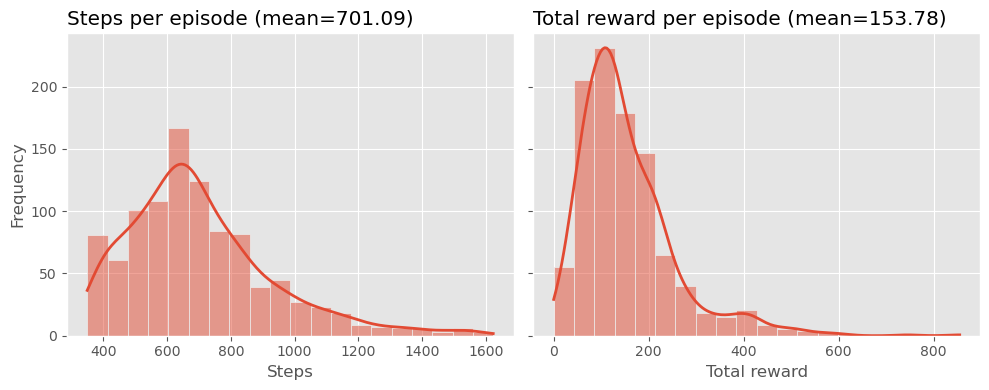

In [9]:
# Plotting the results
def plot_results_hist(n_steps, total_rewards):
    fig, ax = plt.subplots(1,2,figsize=(10,4), sharey=True)
    sns.histplot(x=n_steps, ax=ax[0], bins=20, kde=True)
    ax[0].set_title(f'Steps per episode (mean={n_steps.mean():.2f})')
    ax[0].set_xlabel('Steps')
    ax[0].set_ylabel('Frequency')
    sns.histplot(x=total_rewards, ax=ax[1], bins=20, kde=True)
    ax[1].set_title(f'Total reward per episode (mean={total_rewards.mean():.2f})')
    ax[1].set_xlabel('Total reward')
    ax[1].set_ylabel('Frequency')
    fig.tight_layout()
    plt.show()
    
plot_results_hist(n_steps, total_rewards)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis (0.3 ptos):</strong> ¿Cuál es la media de recompensas obtenida? ¿Y la media de pasos por episodio? Comenta los resultados obtenidos.
</div>

In [10]:
print(f'Average total reward per episode is: {total_rewards.mean():.2f}')
print(f'Average steps per episode is: {n_steps.mean():.2f}')

Average total reward per episode is: 153.78
Average steps per episode is: 701.09


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>
<br><br>

Vemos que el número de pasos medio en cada episodio es muy bajo, de aproximadamente 700 pasos. Teniendo en cuenta que cada paso es un frame del juego y tenemos 60 frames por segundo, el tiempo de juego es muy bajo (~11 segundos), ya que "morimos" en pocos segundos, y desde luego mucho antes del tope de pasos que establece el entorno (100.000). Esto evidentemente es debido a que estamos tomando las acciones en el juego de forma totalmente aleatoria. 

La recompensa media acumulada en el episodio es de approximadamente 150 puntos, que se optienen al destruir naves enemigas, y vemos por el histograma que la distribución de la puntuación está más concentrada en torno a su valor más habitual.

</div>

## 2. Agente DQN (2.8 ptos)
En este apartado implementaremos una solución DQN para intentar obtener un modelo que nos permita solucionar este entorno. Primeramente definiremos el modelo de red neuronal, luego describiremos el comportamiento del agente, lo entrenaremos y, finalmente, testearemos el funcionamiento del agente entrenado.


### 2.1 Procesamiento de las observaciones.


El primer paso es entender la estructura de la información que nos proporciona el entorno. Los juegos de Atari utilizan un espacio de acción con una estructura de la siguiente forma (210, 160, 3), es decir, 210 pixeles de anchura, 160 de altura y 3 colores (RGB). Cada uno de estos puntos de la estructura es un pixel de color y posee un rango de valores que van desde el 0 hasta 255, lo que nos da $256^{(210x160x3)}$ = $256^{100800}$ posibilidades (a modo de comparación, tenemos aproximadamente $10^{80}$ átomos en el universo observable)

<p></p>
<img src="imagenes/atomos.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.1 Análisis (0.2 pto):</strong> ¿Es posible implementar una solución tabular vista durante la PEC1 en este entorno de Space Invader?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Respuesta:</strong>
<br><br>

Es evidente que no es posible implementar una solución tabular en este caso, puesto que el espacio de estados es tan grande que sería imposible almacenar en memoria una tabla Q con los valores de pares estado-acción, por no hablar de otros problemas añadidos como el tiempo empleado en explorar todo ese espacio de estados. Por lo tanto, es totalmente imposible implementar una solución tabular en este caso y nos tenemos que ir a soluciones aproximadas.

</div>

En este caso, la mejor idea es, dado un estado, aproximar los valores Q para cada posible acción en ese estado. Es decir, implementaremos la solución que puedes observar en la siguiente figura.

<p></p>
<img src="imagenes/deep.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<p></p>

Ahora bien, en el juego Space Invader no todo el espacio posee utilidad. El marcador, el marco o la cantidad de vidas no es necesario para el desarrollo del juego. Una práctica muy habitual en el aprendizaje por refuerzo es reducir las dimensiones del entorno con el objetivo de disminuir la cantidad de cálculos necesarios para obtener un modelo útil para el entorno.

Exactamente, para esta PEC os vamos a pedir reducir el espacio de los frames a 84 x 84 píxeles, reducir nuestros tres canales de color (RGB) a 1 (blanco y negro), normalizar el resultado y, por último, almacenar los 4 últimos frames cómo se muestra en la siguiente figura:
<p></p>
<img src="imagenes/preprocessing.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2  (0.1 pto):</strong> Define el metodo scale_lumininance para, dado un estado, transformar los puntos del sistema RGB al sistema binario blanco y negro
</div>

In [9]:
from skimage.color import rgb2gray

def scale_lumininance(obs):
    ####### TODO #######
    return rgb2gray(obs)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.3 (0.1 pto):</strong> Define el metodo resize para, dado un estado, redimensionar su tamaño a 84 * 84
</div>

In [10]:
def resize(obs):
    ####### TODO #######
    # Crop the image to remove the score and margins
    cropped_obs = obs[30:-15, 15:-15]
    return transform.resize(cropped_obs, (84, 84), anti_aliasing=True)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>2.4 Ejercicio (0.1 pto):</strong> Define el metodo normalize para, dado un estado, normalice la imagen
</div>

In [11]:
def normalize(obs):
    ####### TODO #######
    return np.array(obs).astype(np.float32) / 255.0

El resultado que vas a obtener será el siguiente:
<p></p>
<table  border="0">
<thead>
  <tr style='border:none;' >
    <th style='border:none;' ><img src="imagenes/preprocess_grey.png"  width="500"></th>
    <th style='border:none;'><img src="imagenes/preprocess_normalize.png"  width="500"></th>
    <th style='border:none;' ><img src="imagenes/preprocess_size.png"  width="500"></th>
  </tr>
</thead>
<tbody>
  <tr style='border:none;'>
    <td style='text-align: center; border:none;'> 1.scale_lumininance(obs) </td>
    <td style='text-align: center; border:none;'> 2.resize(obs) </td>
    <td style='text-align: center; border:none;'> 3.normalize(obs)</td>
  </tr>
</tbody>
</table></div>


In [12]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
env.reset()
env.render(mode='rgb_array')
action = env.action_space.sample()
state, reward, done, _ = env.step(action)

# Función que realiza todo el pre-procesado de una observación
def preprocess_observation(obs):
    obs_proc = scale_lumininance(obs)
    obs_proc = resize(obs_proc)
    obs_proc = normalize(obs_proc)
    return obs_proc

Comprobamos el correcto funcionamiento de la etapa de preprocesado de cada observación.

In [13]:
preprocessed_obs = preprocess_observation(state)
print(f'Original observation size: {state.shape}')
print(f'Preprocessed observation size: {preprocessed_obs.shape}')

Original observation size: (210, 160, 3)
Preprocessed observation size: (84, 84)


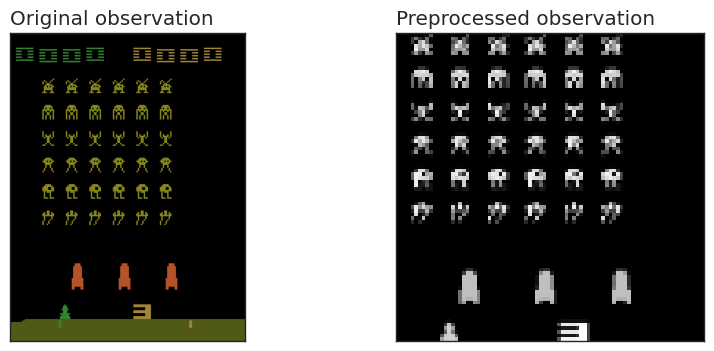

In [14]:
sns.set_style('white')
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(state)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Original observation')
ax[1].imshow(preprocessed_obs, cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Preprocessed observation')
plt.show()

Por último, creamos un Observation Wrapper sobre el entorno para aplicar esta transformación sobre la observación de forma automática.

In [15]:
class preprocess_observation_wrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(84, 84), dtype=np.float32)

    def observation(self, obs):
        return preprocess_observation(obs)

In [16]:
env = gym.make('SpaceInvaders-v4', render_mode='rgb_array')
env = preprocess_observation_wrapper(env)
obs = env.reset()
print(f'Observation space size after preprocessing: {env.observation_space.shape}')

Observation space size after preprocessing: (84, 84)


Por último, ¿cómo interpretamos el movimiento? Las imágenes corresponden a información estática de las partidas y, en este entorno, es importante conocer la dirección del disparo o el movimiento de los invasores. Para ello, una forma de gestionar esta información es apilando fotogramas para poder proporcionar al algoritmo información acerca de la progresión de la partida.


Utilicemos un ejemplo muy claro, el Ping Pong:
<p></p>
<img src="imagenes/temporal-limitation-2.png"  width="1000">

Fíjate cómo la pelota se desplaza hacia la derecha. La agrupación de los frames nos permite trasladar la información espacial a nuestro algoritmo.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.5  (0.1 ptos):</strong> Implementa la función stack_frame para apilar 4 frames de una partida. Dicha función debe apilar inicialmente (cuando is_new = True) el mismo frame 4  veces para, posteriormente, conforme se vayan introduciendo nuevos frames ir substituyendo a los más antiguos.
</div>

In [17]:
from itertools import repeat

def stack_frame(stacked_frames:np.ndarray, frame:np.ndarray, is_new:bool=False, n_frames:int=4) -> np.ndarray:
    """Stacking Frames.
    Params
    ======
        stacked_frames (array): array de frames (al devolverlo debe tener 4 frames)
        frame: Nueva imagen a añadir (hay que borrar la más antigua)
        is_new: Primera vez que se utiliza el array.
        n_frames: Número de frames que se quieren guardar como observacion.
    """
    if is_new:
        # Create a new array with the first frame repeated n_frames times
        stacked_frames = np.stack(arrays=repeat(frame, n_frames), axis=0)
    else:
        # Roll array to the left and add new frame at the end
        stacked_frames = np.roll(stacked_frames, -1, axis=0)
        stacked_frames[-1] = frame
    return stacked_frames

Una vez creada la función la testeamos jugando una partida, almacenando los 4 frames más recientes en cada paso, y finalmente mostramos los 4 últimos frames de la partida.

(4, 84, 84)


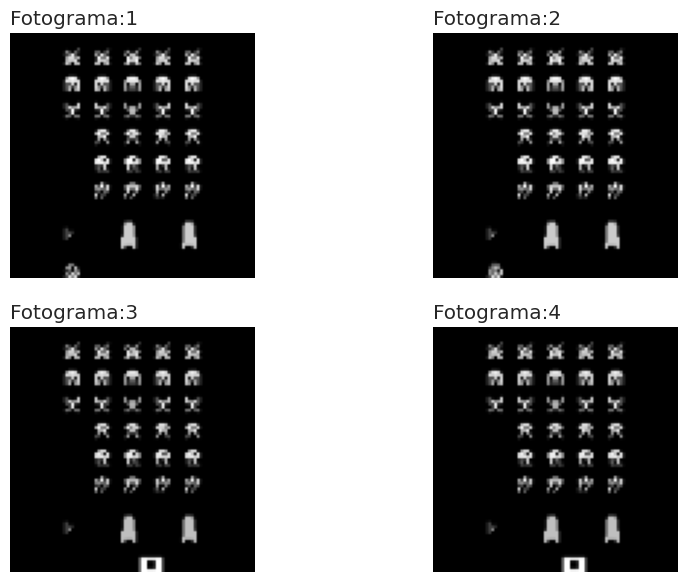

In [18]:
# Llenamos 'state_stack' con 4 copias idénticas del frame inicial de la partida
state_stack= stack_frame(None, env.reset(), True)

# Jugamos una partida aleatoria y vamos actualizando los 4 frames de 'state_stack'
# conforme se van produciendo nuevos
while True:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    state_stack = stack_frame(state_stack, next_state, False)
    if done:
         break

print(state_stack.shape)


# Mostramos los últimos 4 frames de la partida que han quedado almacenados en 'state_stack'
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
cont=1

for i in state_stack:
    fig.add_subplot(rows, columns, cont)
    plt.imshow(i, cmap='gray')
    plt.axis('off')
    plt.title('Fotograma:' + str(cont))
    cont = cont +1

Podemos comprobar como capturamos la dinámica del entorno. Al tratarse de los últimos frames, podemos comprobar la desaparición del jugador entre el frame 2 y el 3, cuando este "muere".

Por último, creamos un nuevo Observation Wrapper sobre el entorno para aplicar este *staking* de 4 frames.

In [19]:
class stack_frame_wrapper(gym.ObservationWrapper):
    def __init__(self, env, n_frames=4):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(n_frames, 84, 84), dtype=np.float32)
        self.state_stack = None
        self.n_frames = n_frames

    def reset(self):
        self.state_stack = stack_frame(None, self.env.reset(), True, self.n_frames)
        return self.state_stack

    def observation(self, obs):
        self.state_stack = stack_frame(self.state_stack, obs, False)
        return self.state_stack

In [20]:
def make_env(env_name:str) -> gym.Env:
    env = gym.make(env_name, render_mode='rgb_array')
    env = preprocess_observation_wrapper(env)
    env = stack_frame_wrapper(env, 4)
    return env

env = make_env('SpaceInvaders-v4')
print(f'Final observation space size: {env.observation_space.shape}')

Final observation space size: (4, 84, 84)


Aplicando ambos wrappers sobre el entorno, comprobamos que éste nos devuelve una observación tal y como queremos.

Ahora con estas modificaciones podemos pasar al siguiente punto, la creación de la Red
<p></p>
<img src="imagenes/deep-q-network.jpg"  width="1000">

Fuente: <href>https://huggingface.co/blog/deep-rl-dqn</href>

Cómo se observa en la imagen, utilizaremos un modelo convolucional (perfecto para detectar patrones en imágenes) junto con un sistema lineal completamente conectado. Para la red convolucional os proponemos la siguiente configuración:

<ul>
    <li>Una primera capa del tipo Conv2d con los siguientes parámetros in_channels=4, out_channels=32, kernel_size=8, stride=4 con activación ReLU.</li>
    <li>Una segunda capa del tipo Conv2d con los siguientes parámetros in_channels=32, out_channels=64, kernel_size=4, stride=2 con activación ReLU.</li>
    <li>Una tercera capa del tipo Conv2d con los siguientes parámetros in_channels=64, out_channels=64, kernel_size=3, stride=1 con activación ReLU.</li>
</ul>

El resultado de esta primera red (3D) lo conectaremos con un modelo complementamente conectado (1D) con la siguiente estructura lineal:

* Una primera capa completamente conectada (representada en pytorch por nn.Lineal) de 512 neuronas, con activación ReLU
* Una última capa completamente conectada. Esta será nuestra capa de salida y, por lo tanto, tendrá tantas neuronas como dimensiones tenga nuestro espacio de acciones (una salida por cada acción posible).

Por último, usaremos el optimizador Adam para entrenar la red.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 2.6 (0.5 ptos):</strong>Implementar la clase  <code>DQN_CNN()</code>. Inicializar las variables necesarias y definir el modelo CNN y linial indicado.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.

</div>

In [21]:
class DQN_CNN(nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super(DQN_CNN, self).__init__()
        """
        Params
        ======
        n_inputs: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        red_cnn: definición de la red convolucional
        red_lineal: definición de la red lineal
        """
        #######################################
        ###TODO: inicialización y modelo###
        self.input_shape = env.observation_space.shape
        self.n_outputs = env.action_space.n
        self.device = device
        
        #######################################
        ##TODO: Construcción de la red neuronal convolucional
        self.red_cnn = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        ).to(device)
        
        self.fc_layer_inputs = self.feature_size()
        
        #######################################
        ##TODO: Construcción de la red neuronal lineal completamente conectada
        self.red_lineal = nn.Sequential(
            nn.Flatten(), # This first layer flattens the input, all but the first dimension (batch dimmension)
            nn.Linear(self.fc_layer_inputs, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_outputs)
        ).to(device)

        #######################################
        ##TODO: Inicializar el optimizador
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)


    #######################################
    #####TODO: función forward#############
    def forward(self, x):
        '''Forward pass through the network'''
        x = self.red_cnn(x)
        # Since we have the flatten layer, we don't need to reshape CNN's output
        x = self.red_lineal(x)
        return x


    def get_qvals(self, state):
        # If we receive a tuple, we add a batch dimension to state
        if type(state) is tuple:
            state = np.array(state)
        # If state has only one observation, we add the batch dimension
        if state.ndim == 3:
            state = np.expand_dims(state, axis=0)
        # Convert to tensor and send to device
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.forward(state_t)
    
    # la seleccion e-greedy de la acción la he implementado en el agente, no en la red

    def feature_size(self):
        return self.red_cnn(autograd.Variable(torch.zeros(1, *self.input_shape)).to(device=self.device)).view(1, -1).size(1)


Visualizamos la red creada y comprobamos su funcinamiento introduciendo en ella una observación.

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = DQN_CNN(env, learning_rate=0.001, device=device)
print(net)
obs = env.reset()
print(f'Input tensor to the CNN: {obs.shape}')
output = net.get_qvals(obs)
print(f'Output tensor:{output}')
print(f'Output tensor shape:{output.shape}')

DQN_CNN(
  (red_cnn): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (red_lineal): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=6, bias=True)
  )
)
Input tensor to the CNN: (4, 84, 84)
Output tensor:tensor([[ 0.0432, -0.0027,  0.0088, -0.0138,  0.0361,  0.0046]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Output tensor shape:torch.Size([1, 6])


Definimos la clase para el *buffer* de repetición de experiencias:


In [23]:
from collections import namedtuple, deque

class experienceReplayBuffer:
    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer',
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size,
                                   replace=False)
        # Use el operador asterisco para desempaquetar deque
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

### 2.2 Definición del agente


A continuación implementaremos una clase que defina el entrenamiento del agente teniendo en cuenta:
    <ul>
        <li>La exploración/explotación (decaimiento de epsilon)</li>
        <li>La actualización y sincronización de la red principal y la red objetivo (pérdida)</li>
    </ul>

Además, vamos a considerar que el agente ha superado el entorno cuando obtenga una puntuación superior a 350 en 100 partidas

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.7 (1 pto):</strong> Implementar los siguientes puntos de la clase <code>DQNAgent()</code>:
    <ol>
        <li>Declarar las variables de la clase</li>
        <li>Inicializar las variables necesarias</li>
        <li>Implementar la acción a tomar</li>
        <li>Actualizar la red principal según la frecuencia establecida en los hiperparámetros</li>
        <li>Calcular la ecuación de Bellman</li>
        <li>Sincronizar la red objetivo según la frecuencia establecida en los hiperparámetros</li>
        <li>Calcular la media de recompensas de los últimos 100 episodios</li>
        <li>Actualizar epsilon según: $$\textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, 0.01)$$ </li>
    </ol>
Además, durante el proceso se deben almacenar (*):
    <ul>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias de los 100 episodios anteriores</li>
        <li>La pérdida durante el entrenamiento</li>
        <li>La evolución de epsilon a lo largo del entrenamiento</li>
    </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.
</div>

In [24]:
from copy import deepcopy, copy

class DQNAgent:
    ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, main_network, device,
                 buffer, reward_threshold,
                 epsilon=0.1, eps_decay=0.99, eps_min=0.01, batch_size=32, nblock=100,
                 writer=None):
        """"
        Params
        ======
        env: entorno
        main_network: clase con la red neuronal diseñada
        target_network: red objetivo
        buffer: clase con el buffer de repetición de experiencias
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa
        device: dispositivo
        actions: array de acciones posibles
        """

        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # red objetivo (copia de la principal)
        self.buffer = buffer
        self.writer = writer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock
        self.reward_threshold = reward_threshold
        self.device = device
        self.actions = [i for i in range(env.action_space.n)]
        self.initialize()

    ###############################################################
    #####TODO 2: inicialitzar variables extra que es necesiten######
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.epsilons = []
        self.losses = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        # Since we have wrapped the environment, we can use it directly
        self.state0 = self.env.reset()
        
    
    ### e-greedy method
    def get_action(self, state, epsilon=0):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)
        else:
            qvals = self.main_network.get_qvals(state)
            action= torch.max(qvals, dim=-1)[1].item()
        return action


    #################################################################################
    ######TODO 3:  Tomar nueva acción ###############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.get_action(self.state0, eps)# acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1

        #TODO: Realización de la acción y obtención del nuevo estado y la recompensa.
        new_state, reward, done, _ = self.env.step(action)
        # No tenemos que preprocessar el estado porque ya lo hemos hecho en el wrapper
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiencia en el buffer
        self.state0 = new_state

        #TODO: resetear entorno 'if done'
        if done:
            self.state0 = self.env.reset() # No tenemos que preprocessar el estado porque ya lo hemos hecho en el wrapper
        return done


    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        self.gamma = gamma
        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')
        print("Replay buffer filled.")
        episode = 0
        training = True
        print("Training...")
        maximo = 0
        pbar = tqdm(desc='Training', total=max_episodes)
        while training:
            self.state0 = self.env.reset() # No tenemos que preprocessar el estado porque ya lo hemos hecho en el wrapper
            self.total_reward = 0
            gamedone = False
            pbar.update(1)
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')

                #################################################################################
                ###TODO 4: Actualizar red principal según la frecuencia establecida#####
                if not self.step_count % dnn_update_frequency:
                    self.update()

                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if not self.step_count % dnn_sync_frequency:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(episode)

                if gamedone:
                    episode += 1
                    ##################################################################
                    ########TODO: Almacenar epsilon, training rewards i loss#######

                    ##################################################################
                    self.training_rewards.append(self.total_reward) # guardamos las recompensas obtenidas
                    self.epsilons.append(self.epsilon) # guardamos los epsilon
                    ep_loss = np.mean(np.array(self.update_loss)) # calculamos la media de la loss
                    self.losses.append(ep_loss) # guardamos las pérdidas
                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar#####
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    
                    ##################################################################
                    ### Add to tensorboard
                    if self.writer is not None:
                        self.writer.add_scalar("epsilon", self.epsilon, episode)
                        self.writer.add_scalar("loss", ep_loss, episode)
                        self.writer.add_scalar("reward", self.total_reward, episode)
                        self.writer.add_scalar("mean_reward", mean_rewards, episode)
                    
                    self.update_loss = []
                    
                    ##################################################################

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} , Loss {:.2f}\t\t".format(
                        episode, mean_rewards, self.epsilon, ep_loss), end="")

                    # Comprobar si se ha llegado al máximo de episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break

                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    # y se ha entrenado un mínimo de episodios
                    if mean_rewards >= self.reward_threshold and min_episodios < episode:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

                    #################################################################################
                    ######TODO 8: Actualizar epsilon ########
                    self.epsilon = max(self.epsilon * self.eps_decay, min_epsilon)


    ####################################
    #####TODO 5: Cálculo de la pérdida ####
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device)
        actions_vals = torch.LongTensor(np.array(actions)).to(device=self.device).reshape(-1,1)
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q de la red objetivo El parametro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales

        #################################################################################
        ###TODO: Calculamos ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals

        loss = nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss


    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch)# calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().to('cpu').item())


### 2.3 Entrenamiento
A continuación entrenaremos el modelo con los siguientes hiperparámetros:
   <ul>
        <li>Velocidad de aprendizaje: 0.001 </li>
        <li>Tamaño del batch: 32</li>
        <li>Capacidad máxima del buffer: 8000</li>
        <li>Gamma: 0.99</li>
        <li>Epsilon: 1, con decaimiento de 0.995 con un mínimo de 0.01</li>
        <li>Número de steps para rellenar el buffer: 100</li>
        <li>Número máximo de episodios: 5000</li>
        <li>Número minímo de episodios: 250</li>
        <li>Frecuencia de actualización de la red neuronal: 100 </li>
        <li>Frecuencia de sincronización con la red objetivo: 5000</li>
    </ul>

Es probable que con los hiperparámetros propuestos no se llegue a solucionar el entorno (conseguir una puntuación de 350 en la media de 100 partidas). El objetivo principal es mejorar los resultados del agente aleatorio.

Está permitido realizar modificaciones en los parámetros presentados aunque, el último ejercicio de esta PEC, consiste en mejorar los resultados obtenidos con este entrenamiento.  Por lo tanto, aunque esté permitido, no es recomendable.

Si el alumno no dispone de suficiente tiempo puede acortar el tiempo de entrenamiento fijando el Número máximo de episodios = 3000 en lugar de los 5000 propuestos.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.8 (0.1 ptos):</strong> Declarar los hiperparámetros, cargar el modelo de red neuronal y entrenar el agente
</div>

In [26]:
LR = 0.001            #Velocidad de aprendizaje
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
BURN_IN = 100        #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
MAX_EPISODES = 5000   #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)

EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .995  #Decaimiento de epsilon
EPSILON_MIN = 0.01    #Valor mínimo de epsilon
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman

BATCH_SIZE = 32       #Conjunto a coger del buffer para la red neuronal

DNN_UPD = 100         #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 5000       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

REWARD_THRESHOLD = 350 #Umbral de recompensa para considerar que el agente ha aprendido

# Environment with wrappers
env = make_env('SpaceInvaders-v4')

# Device selection
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

# SummaryWriter to send to TensorBoard
writer = SummaryWriter(Path('runs') / 'DQN' / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# Experience Replay Buffer
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Main neural network (CNN) and send it to GPU is available
dqn = DQN_CNN(env, learning_rate=LR, device=device)
writer.add_graph(dqn, torch.Tensor(env.reset()).to(device).unsqueeze(0))

# Agent definition
DQN_agent = DQNAgent(
    env=env,
    main_network=dqn,
    device=device,
    buffer=buffer, 
    reward_threshold=REWARD_THRESHOLD,
    epsilon=EPSILON, 
    eps_decay=EPSILON_DECAY, 
    batch_size=BATCH_SIZE, 
    nblock=100,
    writer=writer
    )

# Train agent
DQN_agent.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE, 
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC)

Using device: cuda
Filling replay buffer...
Replay buffer filled.
Training...


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 5000 Mean Rewards 210.70 Epsilon 0.01 , Loss 16.26			, Loss 5.08				
Episode limit reached.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.9 (0.1 ptos):</strong> Representar:
    <ol>
        <li>Gráfico con las recompensas obtenidas a lo largo del entrenamieno, la evolución de las recompensas medias y el umbral de recompensa establecido por el entorno.</li>
        <li>Gráfico con la evolución de la perdida a lo largo del entrenamiento</li>
        <li>Gráfico con la evolución de epsilon a lo largo del entrenamiento</li>
</div>

In [27]:
def plot_results(rewards, mean_rewards, reward_threshold, losses, epsilon):
    sns.set_style('darkgrid')
    n = len([met for met in [rewards, losses, epsilon] if met is not None])
    fig, ax = plt.subplots(n, 1, figsize=(10, n*3), sharex=True)
    # Rewards
    episodes = range(len(rewards))
    sns.lineplot(x=episodes, y=rewards, label='Reward', ax=ax[0], lw=0.5, alpha=0.5)
    sns.lineplot(x=episodes, y=mean_rewards, label='Mean reward', ax=ax[0], lw=1)
    sns.lineplot(x=episodes, y=reward_threshold, label='Reward threshold', ax=ax[0])
    ax[0].set_title('Rewards vs. Episodes')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    # Losses
    sns.lineplot(x=episodes, y=losses, ax=ax[1], lw=1)
    ax[1].set_title('Losses vs. Episodes')
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Loss')
    plt.tight_layout()
    # Epsilon
    if epsilon is not None:
        sns.lineplot(x=episodes, y=epsilon, ax=ax[2])
        ax[2].set_title('Epsilon vs. Episodes')
        ax[2].set_xlabel('Episodes')
        ax[2].set_ylabel('Epsilon value')
    plt.tight_layout()
    plt.show()

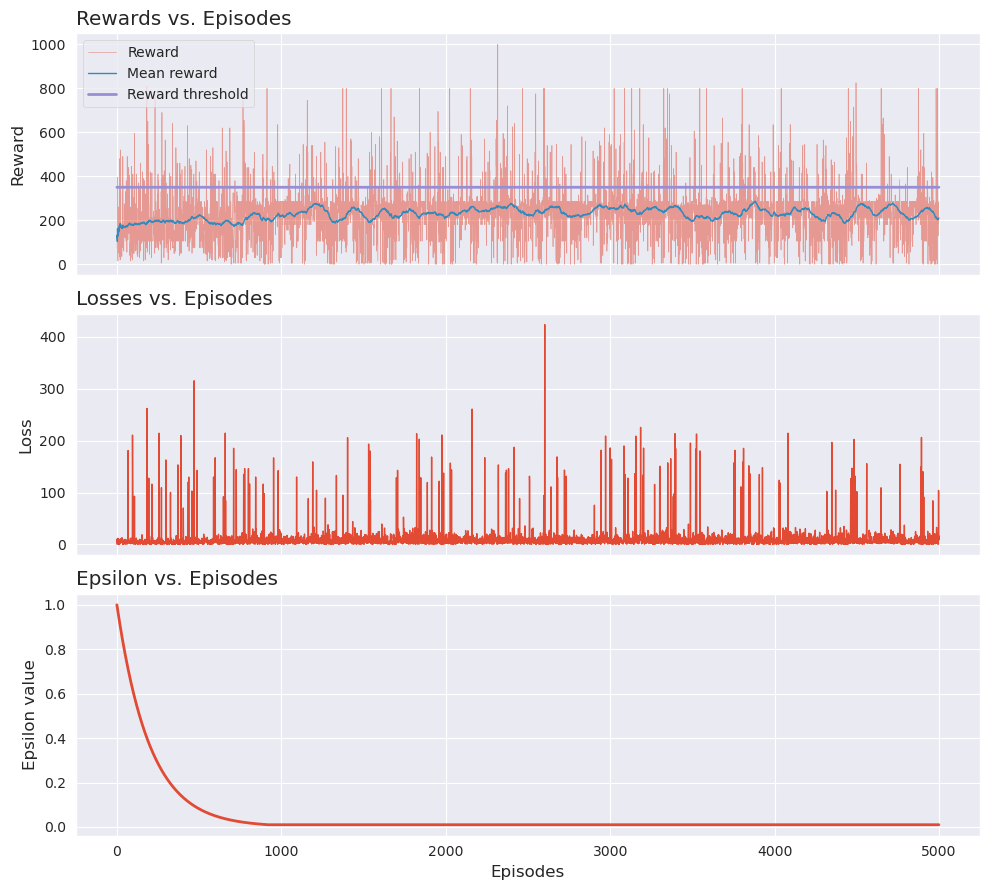

In [28]:
plot_results(rewards = DQN_agent.training_rewards, 
             mean_rewards = DQN_agent.mean_training_rewards, 
             reward_threshold = DQN_agent.reward_threshold,
             losses = DQN_agent.losses,
             epsilon = DQN_agent.epsilons)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 2.10 (0.1 ptos):</strong> Comenta los resultados
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>

Ahora

</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 2.11 (0.1 pto):</strong> Guardar el modelo entrenado en formato ".pth".
</div>

Creamos una función para, además de guardar los parámetros de la red entrenada, también guardar los parámetros que hemos guardado a lo largo del entrenamiento y así los podamos cargar cuando lo deseemos.

In [118]:
def save_agent_training_data(agent, filename):
    agent_data = dict()
    agent_data['training_rewards'] = agent.training_rewards
    agent_data['mean_training_rewards'] = agent.mean_training_rewards
    try:
        agent_data['epsilon'] = agent.epsilon
    except AttributeError:
        pass
    agent_data['losses'] = agent.losses
    try:
        agent_data['nn_parameters'] = agent.main_network.state_dict()
    except AttributeError:
        agent_data['nn_parameters'] = agent.dnnetwork.state_dict()
    with open(filename, 'wb') as f:
        pickle.dump(agent_data, f)
        
Path('trained_models').mkdir(parents=True, exist_ok=True)
path_trained_dqn = Path('trained_models') / 'DQN_Data.pkl'
save_agent_training_data(DQN_agent, path_trained_dqn)

### 2.4 Test del agente entrenado

Una vez entrenado el agente, nos interesa comprobar cómo de bien ha aprendido, si el "robot" es capaz de realizar las tareas aprendidas. Para ello, recuperamos el modelo entrenado y dejamos que el agente tome acciones aleatorias según ese modelo y observamos su comportamiento.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.12 (0.2 pto):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 20 episodios consecutivos. Calcular la suma de recompensas para cada episodio. Mostrar en un gráfico la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido por el entorno.

</div>

In [30]:
def play_episode(env:gym.Env, agent) -> tuple[float, int]:
    '''Plays an episode and returns the total reward and number of steps taken'''
    # Environment initialization
    obs = env.reset()
    total_reward, done, n_steps = 0, False, 0

    while not done:
        # Elegir la accion aprendida por el agente en modo explotacion (epsilon=0)
        action = agent.get_action(obs)
        # Ejecutar la acción y esperar la respuesta del entorno
        new_obs, reward, done, info = env.step(action)
        # Actualizar variables
        obs = new_obs
        total_reward += reward
        n_steps += 1
    return total_reward, n_steps


def play_episodes(env:gym.Env, agent, n_episodes:int) -> tuple[np.ndarray, np.ndarray]:
    '''Plays n_episodes episodes and returns the total reward and number of steps taken'''
    total_rewards = []
    n_steps = []
    for i in tqdm(range(n_episodes)):
        total_reward, steps = play_episode(env, agent)
        total_rewards.append(total_reward)
        n_steps.append(steps)
    return np.array(total_rewards), np.array(n_steps)

In [31]:
def plot_test_episodes(total_rewards, reward_threshold):
    fig, ax = plt.subplots()
    episodes = range(len(total_rewards))
    sns.lineplot(x=episodes, y=total_rewards, label='Reward', ax=ax)
    sns.lineplot(x=episodes, y=reward_threshold, label='Reward threshold', ax=ax)
    ax.set_title(f'Reward vs. Episodes (Mean reward: {total_rewards.mean():.2f})')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Reward')
    ax.set_xticks(episodes)
    plt.show()

In [121]:
# Load agent's data
with open(path_trained_dqn, 'rb') as f:
    dqn_training_data = pickle.load(f)
dqn_training_data.keys()

dict_keys(['training_rewards', 'mean_training_rewards', 'epsilon', 'losses', 'nn_parameters'])

  0%|          | 0/20 [00:00<?, ?it/s]

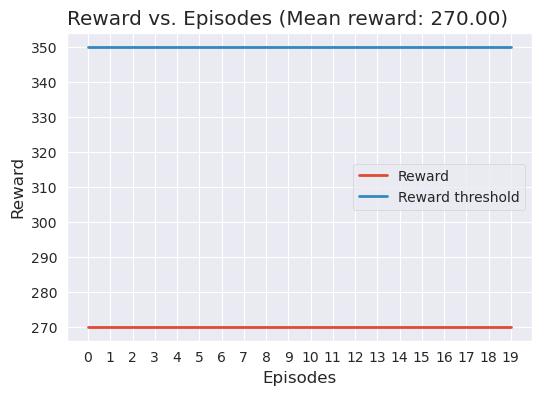

In [124]:
# Load agent's training data
with open(path_trained_dqn, 'rb') as f:
    dqn_training_data = pickle.load(f)
# Load agent's neural network parameters
DQN_agent.main_network.load_state_dict(dqn_training_data['nn_parameters'])
# Play episodes
env = make_env('SpaceInvaders-v4')
total_rewards_dqn, n_steps_dqn = play_episodes(env, DQN_agent, 20)
# Plot results
plot_test_episodes(total_rewards_dqn, REWARD_THRESHOLD)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 2.13 (0.1 pto):</strong> Almacena una partida de ejemplo del agente en la carpeta videos en formato GIF para poder visualizar su comportamiento (se da el código hecho) y comenta el comportamiento del agente entrenado.
</div>

In [33]:
# Creamos el entorno con los wrappers
env = make_env('SpaceInvaders-v4')

def save_agent_gif(env, ag, nombre_fichero):
    '''
    :param env:  entorno GYM
    :param ag:  agente entrenado
    :param nombre_fichero:  nombre del fichero
    :return:
    '''
    frames = []
    env.reset()
    state = env.reset()
    #incio_juego = preprocess_observation(observation)
    #state = stack_frame(None, incio_juego, True)
    total_reward = 0
    t=0
    while True:
        #state= stack_frame(state, preprocess_observation(observation), False)
        frame = env.render(mode='rgb_array')
        frames.append(_label_with_text(frame))
        action = ag.get_action(state)
        observation, reward, done, info = env.step(action)
        total_reward += reward
        t=t+1
        if done:
            break
    env.close()
    try:
        os.makedirs('videos')
    except:
        pass
    imageio.mimwrite(os.path.join('./videos/', nombre_fichero), frames, fps=60)
    
save_agent_gif(env, DQN_agent, 'agente_dqn.gif')

Puede ser que el resultado sea muy parecido al siguiente GIF. No os preocupéis, con los parámetros escogidos es difícil obtener unos mejores resultados.

![title](videos/space_invader_dqn_comportamiento_continuo.gif)

El resultado que obtenemos jugando un episodio con nuestro agente entrenado es el siguiente, que como puede observarse es el mismo que el proporcionado.

![title](videos/agente_dqn.gif)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Respuesta:</strong>
<br><br>

De las imágenes anteriores vemos como nuestro agente entrenado ha tenido el mismo comportamiento que la referencia que se nos da. Esto es debido a que, por un lado, los juegos de Atari tienen un comienzo determinista siempre en el mismo estado, y por otro, a que las acciones que vamos a tomar van a ser deterministas siempre dado un estado. En entrenamiento, tomamos una política epsilon-greedy con epsilon>0 como compromiso entre exploración y explotación, pero en este caso, al estar en modo explotación, vamos a fijar epsilon a 0, por lo que la acción a tomar será determinista. Por lo tanto, siempre tomaremos las mismas decisiones, y partiendo del mismo estado, llegaremos al mismo resultado, obtieniendo siempre el mismo reward, como puede observarse en la gráfica anterior.

Además, como puede observarse en el gif, el comportamiento del agente es bastante pobre y la puntuación que se obtiene también lo es, aunque se ha superado notablemente aquella que obteníamos tomando acciones aleatorias, de en torno a 150.

</div>


## 3. Agente Dueling DQN (2.2 ptos)

En este apartado resolveremos el mismo entorno con las mismas características para el agente, pero usando una dueling DQN. Como en el caso anterior, primero definiremos el modelo de red neuronal, luego describiremos el comportamiento del agente, lo entrenaremos y, finalmente, testearemos el funcionamiento del mismo.

### 3.1 Definición de la arquitectura  de la red neuronal


El objetivo principal de las dueling DQN es "ahorrarse" el cálculo del valor de Q en aquéllos estados en los que es irrelevante la acción que se tome. Para ello se descompone la función Q en dos componentes:


$$Q(s, a) = A(s, a) + V (s)$$


Esta descomposición se realiza a nivel de la arquitectura de la red neuronal. Las primeras capas que teníamos en la DQN serán comunes, y luego la red se dividirá en dos partes separadas definidas por el resto de capas.

La descomposición en sub-redes del modelo de la DQN implementada en el apartado anterior, será entonces:
<ol>
    <li>Bloque común, la red CNN</li>
    <li>Red advantage A(s,a):</li>
         <ul>
             <li>Una primera capa completamente conectada (representada en pytorch por nn.Lineal) de 512 neuronas, con activación ReLU</li>
             <li>Una última capa completamente conectada. Esta será nuestra capa de salida y por lo tanto el número de neuronas de salida dependerá del tipo de red, A(s,a) en este caso, y tendrá tantas neuronas como dimensiones tenga el espacio de acciones.</li>
             </ul>
    <li>Red value V(s):</li>
            <ul>
             <li>Una primera capa completamente conectada (representada en pytorch por nn.Lineal) de 512 neuronas, con activación ReLU</li>
             <li>Una última capa completamente conectada. Esta será nuestra capa de salida con un valor por estado.</li>
             </ul>
</ol>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.1 (0.75 ptos):</strong> Implementar la clase <code>duelingDQN()</code>. Inicializar las variables necesarias y definir el modelo Funcional de red neuronal indicado.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.
</div>

In [66]:
class duelingDQN(nn.Module):
    ###################################
    ###TODO: inicialización y modelo###
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        """
        Params
        ======
        input_shape: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        device: device to use for tensor operations; 'cpu' for CPU or 'cuda' for GPU
        red_cnn: definición de la red convolucional
        value: definición de la red lineal value
        advantage: definición de la red lineal advantage
        """
        ###################################
        ####TODO: Inicializar variables####
        super(duelingDQN, self).__init__()
        self.input_shape = env.observation_space.shape
        self.n_outputs = env.action_space.n
        self.device = device
            
        #######################################
        ##TODO: Construcción de la red neuronal
        
        # Common CNN
        self.red_cnn = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        ).to(self.device)
        
        self.fc_layer_inputs = self.feature_size()
        
        # Fully connected advantage network - we have one output per action
        self.advantage = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_layer_inputs, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_outputs)
        ).to(self.device)
        
        # Fully connected value network - we have only one output
        self.value = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_layer_inputs, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        ).to(self.device)
        
        ### Inicializamos el optimizador
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)


    #######################################
    #####TODO: función forward#############
    def forward(self, x):
        '''Forward pass through the network'''
        # We firts pass the input through the common CNN
        x = self.red_cnn(x)
        # This is passed through the value network and the advantage network
        value = self.value(x)
        advantage = self.advantage(x)
        # The value network output is added to the advantage network output minus 
        # the mean of the advantage network output
        return value + (advantage - advantage.mean(dim=1, keepdim=True))


    def get_qvals(self, state):
        '''Returns the Q-values for the given state'''  
        # If we receive a tuple, we add a batch dimension to state
        if type(state) is tuple:
            state = np.array(state)
        # If state has only one observation, we add the batch dimension
        if state.ndim == 3:
            state = np.expand_dims(state, axis=0)
        # Convert to tensor and send to device
        state_t = torch.Tensor(state).to(device=self.device)
        return self.forward(state_t)


    def feature_size(self):
        return self.red_cnn(autograd.Variable(torch.zeros(1, * self.input_shape)).to(device=self.device)).view(1, -1).size(1)


In [67]:
env = make_env('SpaceInvaders-v4')
device = "cuda" if torch.cuda.is_available() else "cpu"
net = duelingDQN(env, learning_rate=0.001, device=device)
print(net)
obs = env.reset()
print(f'Input tensor to the CNN: {obs.shape}')
output = net.get_qvals(obs)
print(f'Output tensor:{output}')
print(f'Output tensor shape:{output.shape}')

duelingDQN(
  (red_cnn): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (advantage): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=6, bias=True)
  )
  (value): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)
Input tensor to the CNN: (4, 84, 84)
Output tensor:tensor([[0.0131, 0.0611, 0.0341, 0.0412, 0.0563, 0.0220]], device='cuda:0',
       grad_fn=<AddBackward0>)
Output tensor shape:torch.Size([1, 6])


Para el buffer de repetición de experiencias podemos usar exactamente la misma clase experienceReplayBuffer descrita en el apartado anterior de la DQN.



### 3.2 Definición del agente


La diferencia entre la DQN y la dueling DQN se centra, como hemos visto, en la definición de la arquitectura de la red. Pero el proceso de aprendizaje y actualización es exactamente el mismo. Así, podemos recuperar la clase implementada en el apartado anterior, DQNAgent() y reutilizarla aquí bajo el nombre de duelingDQNAgent(). Lo único que deberemos hacer es añadir el optimizador entre las variables a declarar y adaptar la función de pérdida al formato Functional de pytorch.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.2 (0.5 pto):</strong> Implementar la clase <code>duelingDQNAgent()</code> como la <code>DQNAgent()</code>
<p>
</p>
De nuevo, durante el proceso se deben almacenar (*):
    <ul>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias de los 100 episodios anteriores</li>
        <li>La pérdida durante el entrenamiento</li>
        <li>La evolución de epsilon a lo largo del entrenamiento</li>
    </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.

In [68]:
class duelingDQNAgent:
 ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, main_network, device,
                 buffer, reward_threshold,
                 epsilon=0.1, eps_decay=0.99, batch_size=32, nblock=100,
                 writer=None):
        """"
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        target_network: red objetivo
        buffer: clase con el buffer de repetición de experiencias
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        actions: array de acciones posibles
        """
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # red objetivo (copia de la principal)
        self.buffer = buffer
        self.writer = writer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock
        self.reward_threshold = reward_threshold
        self.device = device
        self.actions = [i for i in range(env.action_space.n)]
        self.initialize()

    ###############################################################
    #####TODO 2: inicialitzar variables extra que es necessiten######
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.epsilons = []
        self.losses = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()


    ### Método e-greedy
    def get_action(self, state, epsilon=0):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción aleatoria
        else:
            qvals = self.main_network.get_qvals(state)  # acción a partir del cálculo del valor de Q para esa acción
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    

    #################################################################################
    ######TODO 3:  Tomar nueva acción ###############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.get_action(self.state0, eps)# acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1

        #TODO: Realización de la acción y obtención del nuevo estado y la recompensa
        new_state, reward, done, _ = self.env.step(action)

        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardar experiencia en el buffer
        self.state0 = new_state.copy()

        #TODO: resetear entorno 'if done'
        if done:
            # No tenemos que preprocessar el estado porque ya lo hemos hecho en el wrapper
            self.state0 = self.env.reset()
        return done


    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250, min_epsilon = 0.01):
        self.gamma = gamma
        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')
        print("Buffer filled.")
        episode = 0
        training = True
        print("Training...")
        maximo = 0
        pbar = tqdm(desc='Training', total=max_episodes)
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            pbar.update(1)
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')

                #################################################################################
                #####TODO 4: Actualizar la red principal según la frecuencia establecida  #######
                if not self.step_count % dnn_update_frequency:
                    self.update()

                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if not self.step_count % dnn_sync_frequency:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(episode)

                if gamedone:
                    episode += 1
                    ##################################################################
                    ########TODO: Almacenar epsilon, training rewards i loss#######

                    self.training_rewards.append(self.total_reward) # guardamos las recompensas obtenidas
                    self.epsilons.append(self.epsilon) # guardamos los epsilon
                    ep_loss = np.mean(np.array(self.update_loss)) # calculamos la media de la loss
                    self.losses.append(ep_loss) # guardamos las pérdidas
                    self.update_loss = []

                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar#####
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)

                    ##################################################################
                    ### Add to tensorboard
                    if self.writer is not None:
                        self.writer.add_scalar("epsilon", self.epsilon, episode)
                        self.writer.add_scalar("loss", 0, episode)
                        self.writer.add_scalar("reward", self.total_reward, episode)
                        self.writer.add_scalar("mean_reward", mean_rewards, episode)
                    
                    # Print results
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {} , Maximo {:.2f}\t\t".format(
                        episode, mean_rewards, self.epsilon,maximo), end="")

                    # Comprobar si se ha llegado al máximo de episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break

                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    # y se ha entrenado un mínimo de episodios
                    if mean_rewards >= self.reward_threshold and min_episodios <  episode:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

                    #################################################################################
                    ######TODO 8: Actualizar epsilon ########
                    self.epsilon = max(self.epsilon * self.eps_decay, min_epsilon)


     ## Cálculo de la pérdida
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(self.device).reshape(-1,1)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(self.device)
        dones_t = torch.ByteTensor(dones).to(self.device)

        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)

        #DQN update#
        next_actions = torch.max(self.main_network.get_qvals(next_states), dim=-1)[1]
        next_actions_vals = next_actions.reshape(-1,1).to(self.device)
        # Obtenemos los valores de Q de la red objetivo
        target_qvals = self.target_network.get_qvals(next_states)
        qvals_next = torch.gather(target_qvals, 1, next_actions_vals).detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        #####

        #TODO: Calculamos ecuación de Bellman
        expected_qvals = rewards_vals + self.gamma * qvals_next
        
        # Modificar la función de Loss para el modo Functional
        loss = F.mse_loss(qvals, expected_qvals.reshape(-1,1))

        return loss


    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().to('cpu').item())


### 3.3 Entrenamiento
A continuación entrenaremos el modelo dueling DQN con los mismos hiperparámetros con los que entrenamos la DQN.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.3 (0.1 ptos):</strong> Cargar el modelo de red neuronal y entrenar el agente con los mismos hiperparámetros usados para la DQN
</div>

In [73]:
LR = 0.001            #Velocidad de aprendizaje
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
BURN_IN = 1000        #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
MAX_EPISODES = 5000   #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)

EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .995  #Decaimiento de epsilon
EPSILON_MIN = 0.01    #Valor mínimo de epsilon
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman

BATCH_SIZE = 32       #Conjunto a coger del buffer para la red neuronal

DNN_UPD = 10          #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 5000       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

REWARD_THRESHOLD = 350 #Umbral de recompensa para considerar que el agente ha aprendido

# Environment with wrappers
env = make_env('SpaceInvaders-v4')

# SummaryWriter to send to TensorBoard
writer = SummaryWriter(Path('runs') / 'DuelingDQN' / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# Experience Replay Buffer
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Main neural network (CNN)
DuelingDQN_CNN = duelingDQN(env, learning_rate=LR, device=device)
writer.add_graph(DuelingDQN_CNN, torch.Tensor(env.reset()).to(device).unsqueeze(0))

# Agent definition
DuelingDQN_Agent = duelingDQNAgent(
    env=env,
    main_network=DuelingDQN_CNN,
    device=device,
    buffer=buffer, 
    reward_threshold=REWARD_THRESHOLD,
    epsilon=EPSILON, 
    eps_decay=EPSILON_DECAY, 
    batch_size=BATCH_SIZE, 
    nblock=100,
    writer=writer
    )

# Train agent
DuelingDQN_Agent.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE, 
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC)

Filling replay buffer...
Buffer filled.
Training...


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 5000 Mean Rewards 294.05 Epsilon 0.01 , Maximo 0.00		, Maximo 0.00		
Episode limit reached.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.4 (0.2 ptos):</strong> Mostrar los mismos gráficos que con la DQN:
    <ol>
        <li>Recompensas obtenidas a lo largo del entrenamieno y la evolución de las recompensas medias cada 100 episodios, junto con el umbral de recompensa establecido por el entorno</li>
        <li>Pérdida durante el entrenamiento</li>
        <li>Evolución de epsilon a lo largo del entrenamiento</li>
    </ol>
</div>

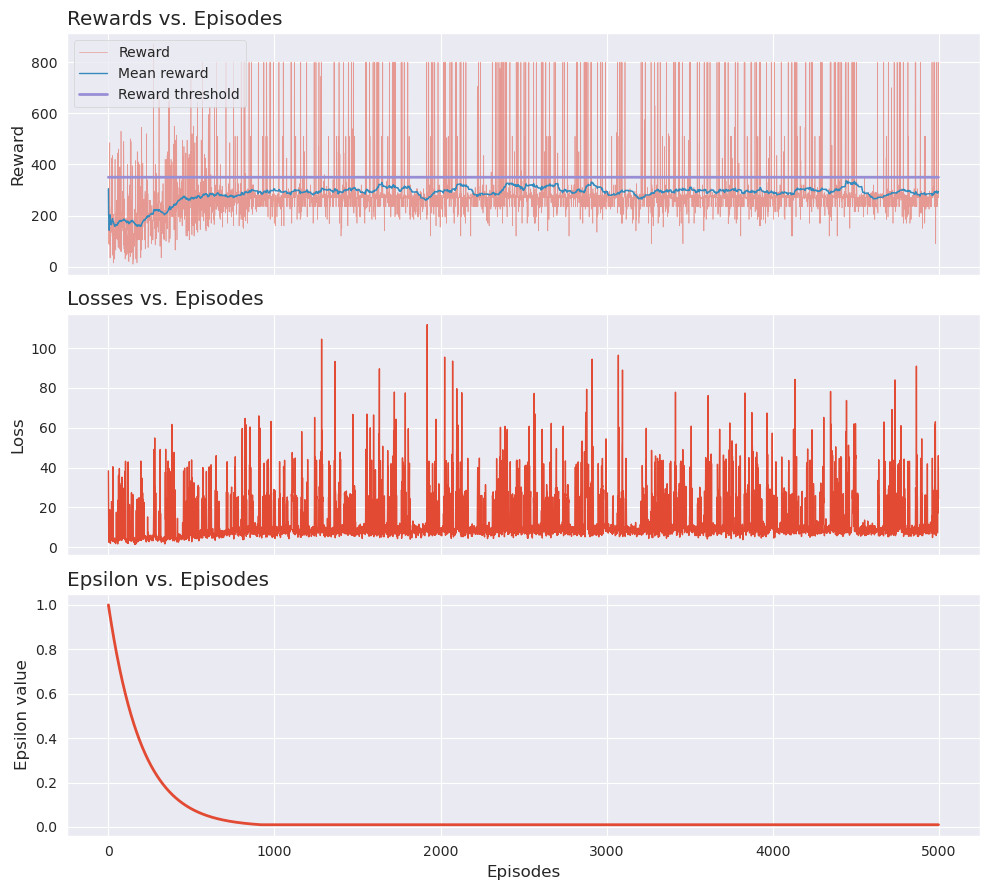

In [74]:
plot_results(rewards = DuelingDQN_Agent.training_rewards, 
             mean_rewards = DuelingDQN_Agent.mean_training_rewards, 
             reward_threshold = DuelingDQN_Agent.reward_threshold,
             losses = DuelingDQN_Agent.losses,
             epsilon = DuelingDQN_Agent.epsilons)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 3.5 (0.1 pto):</strong> Guardar el modelo entrenado en formato ".pth" y comentar los resultados obtenidos.
</div>

In [119]:
Path('trained_models').mkdir(parents=True, exist_ok=True)
path_trained_duelingdqn = Path('trained_models') / 'DuelingDQN_Data.pkl'
save_agent_training_data(DuelingDQN_Agent, path_trained_duelingdqn)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 3.6 (0.1 pto):</strong> Comenta los resultados obtenidos
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>
<br><br>

Se observa en el caso de Dueling DQN una mejora notable en el comportamiento del agente respecto al que teníamos con DQN, ya que pasamos de estabilizarnos en recompensas medias de ~200, a más de 300. En algún momento incluso se llega a rozar al límite de 350 propuesto para dar el entorno como resuelto. Podemos observar además que a partir de el episodio 1000, en el que la epsilon ya ha llegado a su valor mínimio, observamos esta estabilización en la recompensa media.

Si vamos al paper original en el que se propuso el Dueling DQN (<a href="https://arxiv.org/pdf/1511.06581.pdf">enlace</a>), vemos como conseguían en el juego Space Invaders una mejora de 164% sobre el DQN base, que es más que la que hemos experimentado aquí, pero sin tener en cuenta la selección de hiperparámetros de uno ni otros, lo que puede modificar mucho los resultados finales. 

</div>

### 3.4 Test del agente
Finalmente analizamos el comportamiento del agente entrenado.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.7 (0.2 ptos):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 20 episodios consecutivos. Calcular la suma de recompensas por cada episodio. Mostrar en un gráfico la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido por el entorno.


</div>


  0%|          | 0/20 [00:00<?, ?it/s]

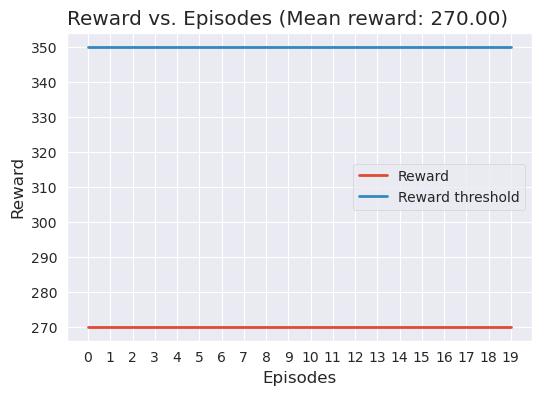

In [125]:
# Load agent's training data
with open(path_trained_duelingdqn, 'rb') as f:
    duelingdqn_training_data = pickle.load(f)
# Load agent's neural network parameters
DuelingDQN_Agent.main_network.load_state_dict(duelingdqn_training_data['nn_parameters'])
# Play episodes
env = make_env('SpaceInvaders-v4')
total_rewards_duelingdqn, n_steps_duelingdqn = play_episodes(env, DuelingDQN_Agent, 20)
# Plot results
plot_test_episodes(total_rewards_duelingdqn, REWARD_THRESHOLD)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 3.8 (0.25 ptos):</strong> Almacena una partida de ejemplo del agente en la carpeta videos en formato GIF para poder visualizar su comportamiento y comenta el comportamiento del agente entrenado.
</div>

In [79]:
env = make_env('SpaceInvaders-v4')
save_agent_gif(env, DuelingDQN_Agent , 'space_invader_duelingDQNAgent_comportamiento.gif')

El resultado que obtenemos jugando un episodio con nuestro agente entrenado es el siguiente.

![title](videos/space_invader_duelingDQNAgent_comportamiento.gif)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>
<br><br>

Como se puede ver en el GIF, la recompensa que obtenemos es mayor que en el caso de DQN, pero a pesar de todo el comportamiento del agente es bastante mejorable, ya que lo único que hace es ir a la parte derecha del plano y disparar.

</div>

## 4. REINFORCE with baseline (2 ptos)

### 4.1 Definición de la arquitectura  de la red neuronal
Utilizaremos un modelo Secuencial con la siguiente configuración:

<ul>
    <li>Una primera capa del tipo Conv2d con los siguientes parámetros in_channels=(8,64,64), out_channels=32, kernel_size=8, stride=4 con activación ReLU.</li>
    <li>Una segunda capa del tipo Conv2d con los siguientes parámetros in_channels=32, out_channels=64, kernel_size=4, stride=2 con activación ReLU.</li>
    <li>Una tercera capa del tipo Conv2d con los siguientes parámetros in_channels=64, out_channels=64, kernel_size=3, stride=1 con activación ReLU.</li>
</ul>

El resultado de esta primera red lo conectaremos con un modelo complementamente conectado con la siguiente estructura lienal:

* Una primera capa completamente conectada (representada en pytorch por nn.Lineal) de 512 neuronas, bias=True y  con activación Tanh
* Una última capa completamente conectada. Esta será nuestra capa de salida y, por lo tanto, tendrá tantas neuronas como dimensiones tenga nuestro espacio de acciones (una salida por cada acción posible), bias=True y activación Softmax (dim=-1).

Por último, usaremos el optimizador Adam para entrenar la red.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.1 (0.5 ptos):</strong> Implementar la clase <code>PGReinforce()</code>. Inicializar las variables necesarias y definir el modelo Secuencial de red neuronal indicado.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>.
</div>

In [80]:
class PGReinforce(nn.Module):

    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        """
        Params
        ======
        n_inputs: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        red_cnn: definición de la red convolucional
        red_lineal: definición de la red lineal
        """
        super(PGReinforce, self).__init__()
         ###################################
        ####TODO: Inicializar variables####
        self.input_shape = env.observation_space.shape
        self.n_outputs = env.action_space.n
        self.device = device
        self.learning_rate = learning_rate
        ######

        #######################################
        ##TODO: Construcción de la red neuronal
        self.red_cnn = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        ).to(self.device)

        self.fc_layer_inputs = self.feature_size()

        self.red_lineal = nn.Sequential(
            nn.Flatten(), # This first layer flattens the input, all but the first dimension (batch dimmension)
            nn.Linear(self.fc_layer_inputs, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_outputs),
            nn.Softmax(dim=-1)
        ).to(self.device)

        #######################################
        ##TODO: Inicializar el optimizador
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #####
    
        
    def forward(self, x):
        x = self.red_cnn(x)
        x = self.red_lineal(x)
        return x

    #Obtención de las probabilidades de las posibles acciones
    def get_action_prob(self, state):
        # If we receive a tuple, we add a batch dimension to state
        if type(state) is tuple:
            state = np.array(state)
        # If state has only one observation, we add the batch dimension
        if state.ndim == 3:
            state = np.expand_dims(state, axis=0)
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.forward(state_t)

    def feature_size(self):
        return self.red_cnn(autograd.Variable( torch.zeros(1, * self.input_shape)).to(device=self.device)).view(1, -1).size(1)

In [81]:
env = make_env('SpaceInvaders-v4')
device = "cuda" if torch.cuda.is_available() else "cpu"
net = PGReinforce(env, learning_rate=0.001, device=device)
print(net)
obs = env.reset()
print(f'Input tensor to the CNN: {obs.shape}')
output = net.get_action_prob(obs)
print(f'Output tensor:{output}')
print(f'Output tensor shape:{output.shape}')
print(f'Sum of elements in output tensor: {output.sum()}')

PGReinforce(
  (red_cnn): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (red_lineal): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=6, bias=True)
    (4): Softmax(dim=-1)
  )
)
Input tensor to the CNN: (4, 84, 84)
Output tensor:tensor([[0.1738, 0.1687, 0.1619, 0.1645, 0.1647, 0.1664]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Output tensor shape:torch.Size([1, 6])
Sum of elements in output tensor: 1.0


Podemos ver como la suma de los elementos de salida es igual a uno, debido a tratarse de una probabilidad derivada de la capa Softmax de salida de la capa completamente conectada de la red neuronal.

### 4.2 Definición del agente
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.2 (0.55 pto):</strong> Implementar los siguientes puntos de la clase <code>reinforceAgent()</code>:
    <ol>
        <li>Declarar las variables de la clase</li>
        <li>Inicializar las variables necesarias</li>
        <li>Implementar la acción a tomar</li>
        <li>Calcular el <i>discounted reward</i> usando como línea de base la media estandardizada del retorno
               $$ \frac{x_i - \bar{x}}{\sigma_x}$$</li>
        <li>Calcular la media de recompensas de los últimos 100 episodios</li>
        <li>Implementar la pérdida por actualización</li>
    </ol>
Además, durante el proceso se deben almacenar (*):
    <ul>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias de los 100 episodios anteriores</li>
        <li>La pérdida durante el entrenamiento</li>
    </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.
</div>

$$ \frac{x_i - \bar{x}}{\sigma_x}$$

In [99]:
class reinforceAgent:

    ###################################################
    ######TODO 1: declarar variables ##################
    def __init__(self, env, dnnetwork, device, nblock, reward_threshold, writer):
        """
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        self.env = env
        self.dnnetwork = dnnetwork
        self.nblock = nblock
        self.reward_threshold = reward_threshold
        self.writer = writer
        self.device = device
        self.action_space = np.arange(self.env.action_space.n)
        self.initialize()
     #######

    ###############################################################
    #####TODO 2: inicializar variables extra que se necesiten######:
    def initialize(self):
       self.batch_rewards = []
       self.batch_actions = []
       self.batch_states = []
       self.batch_counter = 1
       self.training_rewards = []
       self.mean_training_rewards = []
       self.update_loss = []
       self.losses = []
    ######
    
    
    def get_action(self, state):
        # Distribución de probabilidad de las acciones dado el estado actual
        action_probs = self.dnnetwork.get_action_prob(state).detach().to('cpu').numpy() 
        if np.isnan(action_probs).any():
            print("NAN Found")
        # Selección de acción aleatoria de la distribución de probabilidad 
        action = np.random.choice(self.action_space, p=action_probs.squeeze())   #acción aleatoria de la distribución de probabilidad
        return action

    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=2000, batch_size=10):
        self.gamma = gamma
        self.batch_size = batch_size
        episode = 0
        training = True
        print("Training...")
        pbar = tqdm(desc='Training', total=max_episodes)
        while training:
            state0 = self.env.reset()
            episode_states = []
            episode_rewards = []
            episode_actions = []
            gamedone = False
            pbar.update(1)
            while gamedone == False:
                ##########################################################
                ######TODO 3:  Tomar nueva acción ########################
                action = self.get_action(state0)
                next_state, reward, gamedone, _ = env.step(action)
                #######

                # Almacenamos experiencias que se van obteniendo en este episodio
                episode_states.append(state0)
                episode_rewards.append(reward)
                episode_actions.append(action)
                
                # We don't need to apply preprocessing to next_state, because we have the wrapper
                state0 = next_state

                if gamedone:
                    episode += 1
                    # Calculamos el término del retorno menos la línea de base
                    self.batch_rewards.extend(self.discount_rewards(episode_rewards))
                    self.batch_states.extend(episode_states)
                    self.batch_actions.extend(episode_actions)
                    self.batch_counter += 1
                    self.training_rewards.append(sum(episode_rewards))
                    self.losses.append(np.mean(self.update_loss)) # guardamos las pérdidas

                    #####################################################################################
                    ###TODO 5: calcular media de recompensas de los últimos X episodios, y almacenar#####
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    ######
                    
                    ##################################################################
                    ### Add to tensorboard
                    if self.writer is not None:
                        self.writer.add_scalar("loss", np.mean(self.update_loss), episode)
                        self.writer.add_scalar("reward", sum(episode_rewards), episode)
                        self.writer.add_scalar("mean_reward", mean_rewards, episode)


                    # Actualizamos la red cuando se completa el tamaño del batch
                    if self.batch_counter == self.batch_size:
                        self.update(self.batch_states, self.batch_rewards, self.batch_actions)

                        ####################################
                        ###TODO : almacenar training_loss###
                        ###########

                        self.update_loss = []

                        # Reseteamos las variables del epsiodio
                        self.batch_rewards = []
                        self.batch_actions = []
                        self.batch_states = []
                        self.batch_counter = 1

                    print("\rEpisode {:d} Mean Rewards {:.2f}\t\t".format(
                        episode, mean_rewards), end="")

                    # Comprobamos que todavía quedan episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break

                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

    ########################################################
    ###TODO 4: cálculo del retorno menos la línea de base###
    def discount_rewards(self, rewards):
        discount_r = np.zeros_like(rewards)
        timesteps = range(len(rewards))
        reward_sum = 0
        for i in reversed(timesteps):
            reward_sum = rewards[i] + self.gamma*reward_sum
            discount_r[i] = reward_sum
        baseline = discount_r - discount_r.mean()
        return baseline
    ##########


    ## Actualización
    def update(self, batch_s, batch_r, batch_a):
        self.dnnetwork.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        state_t = torch.FloatTensor(batch_s)
        reward_t = torch.FloatTensor(batch_r)
        action_t = torch.LongTensor(batch_a)
        loss = self.calculate_loss(state_t, action_t, reward_t) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.dnnetwork.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().to('cpu').item())

    #################################################
    ###TODO 6: Cálculo de la pérdida#################
    # Recordatorio: cada actualización es proporcional al producto del retorno y el gradiente de la probabilidad
    # de tomar la acción tomada, dividido por la probabilidad de tomar esa acción (logaritmo natural)
    def calculate_loss(self, state_t, action_t, reward_t):
        logprob = torch.log(self.dnnetwork.get_action_prob(state_t))
        selected_logprobs = reward_t * logprob[np.arange(len(action_t)), action_t].squeeze().cpu()
        loss = -selected_logprobs.mean()
        return loss
     ########



### 4.3 Entrenamiento
A continuación entrenaremos el modelo con los siguientes hiperparámetros:
   <ul>
        <li>Velocidad de aprendizaje: 0.005</li>
        <li>Tamaño del batch: 8</li>
        <li>Gamma: 0.99</li>
        <li>Número máximo de episodios: 5000</li>
</ul>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.3 (0.2 ptos):</strong> Definir los hiperparámetros, cargar el modelo de red neuronal y entrenar el agente



In [100]:
LR = 0.005
BATCH_SIZE = 8
GAMMA = 0.99
MAX_EPISODES = 5000
REWARD_THRESHOLD = 350

# Environment with wrappers
env = make_env('SpaceInvaders-v4')

# SummaryWriter to send to TensorBoard
writer = SummaryWriter(Path('runs') / 'REINFORCE' / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# Main neural network (CNN)
REINFORCE_CNN = PGReinforce(env, learning_rate=LR, device=device)
writer.add_graph(REINFORCE_CNN, torch.Tensor(env.reset()).to(device).unsqueeze(0))

# Agent definition
REINFORCE_Agent = reinforceAgent(
    env=env,
    dnnetwork=REINFORCE_CNN,
    device=device,
    reward_threshold=REWARD_THRESHOLD,
    nblock=100,
    writer=writer)

# Train agent
REINFORCE_Agent.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE)

torch.cuda.empty_cache()

Training...


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Episode 5000 Mean Rewards 285.00		
Episode limit reached.


In [ ]:
torch.cuda.empty_cache()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.4 (0.1 ptos):</strong> Mostrar los siguientes gráficos:
    <ol>
        <li>Recompensas obtenidas a lo largo del entrenamieno y la evolución de las recompensas medias cada 100 episodios, junto con el umbral de recompensa establecido por el entorno</li>
        <li>Pérdida durante el entrenamiento</li>
    </ol>
</div>

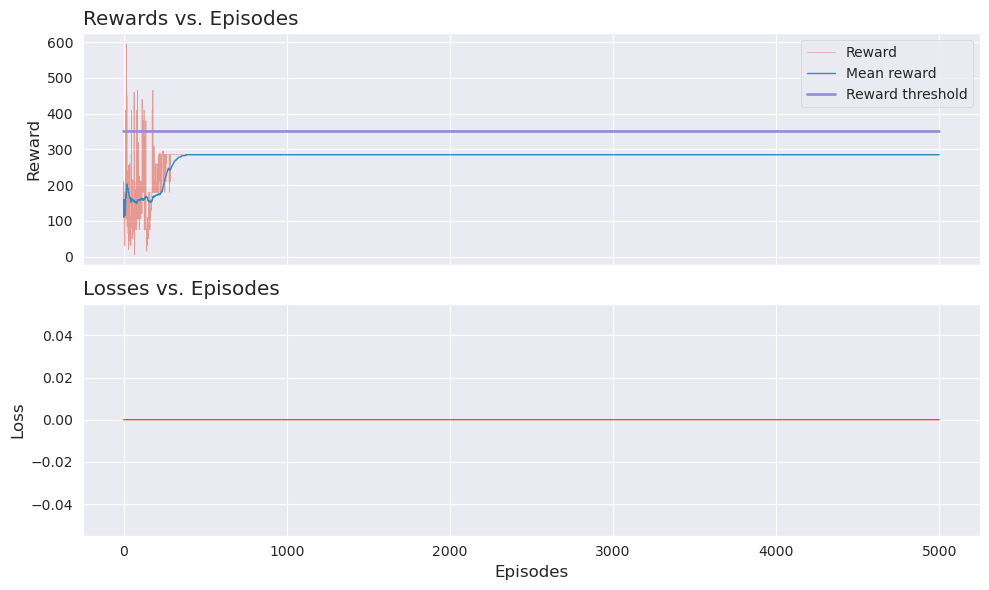

In [101]:
plot_results(rewards = REINFORCE_Agent.training_rewards, 
             mean_rewards = REINFORCE_Agent.mean_training_rewards, 
             reward_threshold = REINFORCE_Agent.reward_threshold,
             losses = 0,
             epsilon = None)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 4.5  (0.2 ptos):</strong> Guardar el modelo entrenado en formato ".pth" y comentar los resultados obtenidos. ¿Qué ha ocurrido con este modelo?
</div>

In [120]:

Path('trained_models').mkdir(parents=True, exist_ok=True)
path_trained_reinforce = Path('trained_models') / 'REINFORCE_Data.pkl'
save_agent_training_data(REINFORCE_Agent, path_trained_reinforce)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>

Es este caso vemos como la recompensa ha ido aumentando hasta alcanzar 285 puntos completamente estables para los parámetros establecidos. Lo que ocurre en este caso es que, llegados a este punto, la red saca unas probabilidades para cada acción que son casi nulas excepto para una de ellas, por lo que siempre se elegirá dicha acción. Además, en este caso no seguimos una política epsilon-greedy, por lo que llegados a este punto todos los episodios vana  comenzar igual (ya que el estado inicial de los juegos de Atari es siempre el mismo) y al tomar las mismas decisiones, se llega al mismo punto, con la misma puntuación.

</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 4.6 (0.15 ptos):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 20 episodios consecutivos. Calcular la suma de recompensas por cada episodio. Mostrar en un gráfico la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido por el entorno. Comentar los resultados.
<p>Almacena una partida de ejemplo del agente en la carpeta videos en formato GIF para poder visualizar su comportamiento y coméntalo.</p>
</div>

  0%|          | 0/20 [00:00<?, ?it/s]

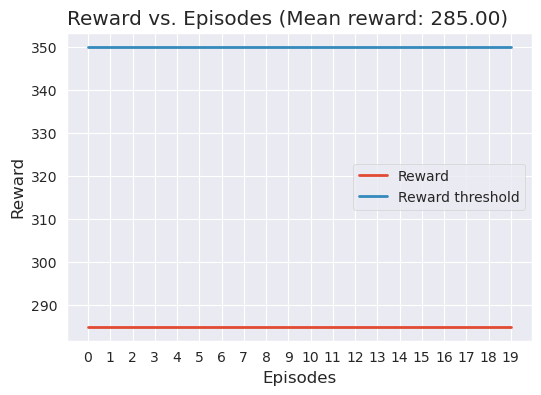

In [126]:
# Load agent's training data
with open(path_trained_reinforce, 'rb') as f:
    reinforce_training_data = pickle.load(f)
# Load agent's neural network parameters
REINFORCE_Agent.dnnetwork.load_state_dict(reinforce_training_data['nn_parameters'])
# Play episodes
env = make_env('SpaceInvaders-v4')
total_rewards_reinforce, n_steps_reinforce = play_episodes(env, REINFORCE_Agent, 20)
# Plot results
plot_test_episodes(total_rewards_reinforce, REWARD_THRESHOLD)

In [104]:
save_agent_gif(env, REINFORCE_Agent , 'space_invader_REINFORCEAgent_comportamiento.gif')

![title](videos/space_invader_REINFORCEAgent_comportamiento.gif)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
</div>

## 5. Comparación de modelos (1 pto)
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 5.1 (0.5 ptos):</strong> Muestra en un mismo gráfico la evolución de la media de recompensas de los tres modelos, junto con el umbral de recompensa.
</div>

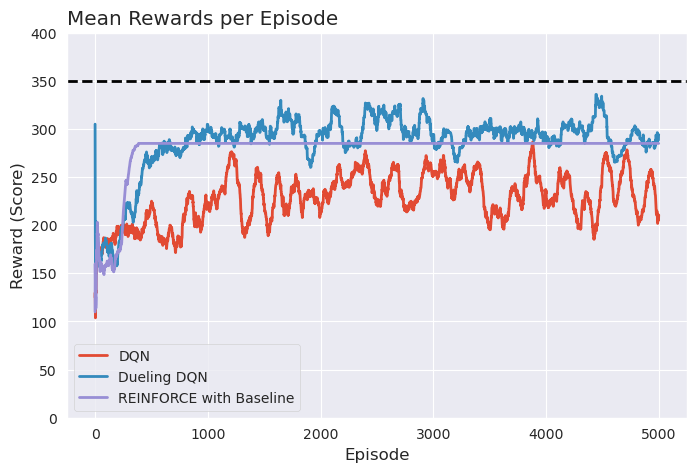

In [127]:
# Load agent's training data
with open(path_trained_dqn, 'rb') as f:
    dqn_training_data = pickle.load(f)
    
with open(path_trained_duelingdqn, 'rb') as f:
    duelingdqn_training_data = pickle.load(f)
    
with open(path_trained_reinforce, 'rb') as f:
    reinforce_training_data = pickle.load(f)

# Plot comparison
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(dqn_training_data['mean_training_rewards'], label='DQN', ax=ax)
sns.lineplot(duelingdqn_training_data['mean_training_rewards'], label='Dueling DQN', ax=ax)
sns.lineplot(reinforce_training_data['mean_training_rewards'], label='REINFORCE with Baseline', ax=ax)
ax.axhline(REWARD_THRESHOLD, label='Reward Threshold', color='black', linestyle='--')
ax.set_ylim(0, 400)
ax.set_title('Mean Rewards per Episode')
ax.set_ylabel('Reward (Score)')
ax.set_xlabel('Episode')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis 5.2 (0.5 ptos):</strong> Analizar los resultados obtenidos teniendo en cuenta el número de episodios, el tiempo de entrenamiento y el rendimiento de los tres agentes entrenados observado en apartados anteriores. ¿Qué agente presenta un mejor comportamiento? ¿Por qué?
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución (Comentarios):</strong>
<br><br>
El 
</div>

## 6. Optimización (1 pto)
En este apartado queremos encontrar la mejor arquitectura e hiperparámetros para optimizar la precisión del modelo. Los puntos que queremos tener en cuenta para la búsqueda del mejor modelo son los siguientes:
<ul>
    <li>Número de unidades de las capas</li>
    <li>Learning rate</li>
    <li>Actualización de la red principal</li>
    <li>Sincronización de la red objetivo</li>
    <li>Batch size</li>
    <li>Gamma</li>
    <li>Número de partidas del entrenamiento</li>
<ul>

Podéis modificar o adaptar la configuración cómo consideréis oportuno siempre y cuando justifiquéis el beneficio y el cambio.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 6.1 :</strong> Elegir uno de los dos modelos de DQN implementados (DQN o dueling DQN) y  experimentar con diferentes combinaciones de valores para los parámetros especificados. El objetivo es conseguir un modelo con mejores resultados que el presentado en la PEC. <b>Indicar</b> las pruebas realizadas, pero presentar <b>únicamente</b> la ejecución y resultados de la mejor opción. Justificar los valores elegidos de hiperparámetros para las distintas pruebas realizadas y comentar los resultados de entrenamiento y de rendimiento del agente entrenado.
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>
<br><br>
</div>

# Bibliografía

https://torres.ai/deep-reinforcement-learning-explained-series/

https://pillow.readthedocs.io/en/stable/reference/Image.html

https://github.com/gouxiangchen/dueling-DQN-pytorch

https://arxiv.org/pdf/1511.06581.pdf